# Wells in Tanzania: Predicting Functionality of Wells

**By:** Lauren Esser

**Blog post URL:**
> https://lauren-esser.github.io/your_guide_to_jupyter_markdowns


# Business Understanding

Water is essential to all of life. In America, we take for granted our access to free, clean water.  Currently 4 million people in Tanzania lack access to a safe source of water and 30 million don't have access to improved sanitation. By being able to predict the functionality of wells in Tanzania, we are able to help out in this humanitarian crisis for those who do not have the luxury of going to their sink for a glass of water.

![]()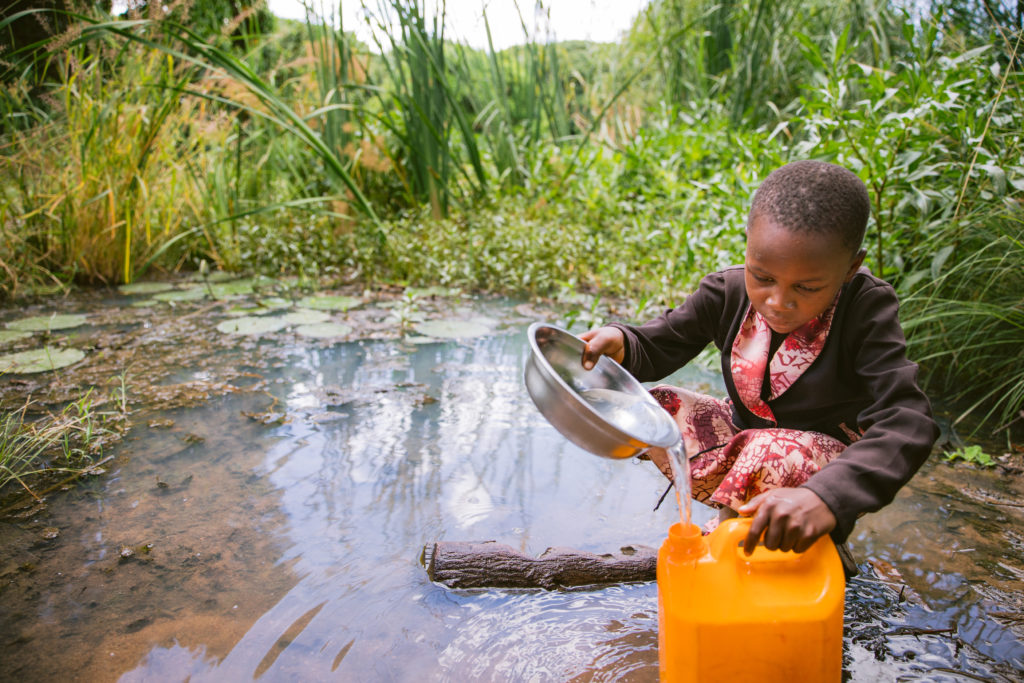

# Abstract

Within this notebook I used the OSEMN process to predict the functionality of
wells in Tanzania. To begin, I obtained the data from [Driven Data](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/) . I scrubbed the data by taking a look at the nulls using Missingo. I could see that many of the columns shared the exact same information and went through to see what was valuable information versus what was repetitive and could be deleted. During the Explore section I took a look at visualizations, dealt with categorical columns using OHE, and performed a train test split. I then began the Modeling process testing out a handful of Machine Learning Models. These include Decision Trees, Bagged Trees, Naive Bayes, Random Forest, Adaboost, and using GridsearchCV to identify the best parameters for each. The Random Forest Model using GridsearchCV provided the best results with 80% accuracy, Macro-Average ROC Curve of 89%, 71% precision, and 67% recall. The recommendations identified in the notebook are as follows:

1. Ensure water pumps have access to a water source.
    
2. Monitor wells that use extraction type of Gravity, Nira, or are labeled as “Other”.

3. Monitor wells that use waterpoint type of Handpump, Standpipe, or are labeled as “Other”. 

4. Inspect pumps that are built before 1965 or have no construction year listed.

# Introduction

The goal of this notebook is to predict which water pumps in Tanzania are functional, which need repairs, and which pumps do not work at all. By gaining a better understanding of factors that impact water pumps we are able to improve maintenance and ensure all pumps stay functional. The importance of having potable water for these Tanzanian communities is that it decreases diseases, increases education, and increases the economy overall. Data was obtained from [Driven Data](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/) and the OSEMN method was used to execute the notebook. Different models that were tested include Decision Trees, Bagged Trees, Naive Bayes, Random Forests, and Adaboost.

# Obtain Data

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno 
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from yellowbrick.classifier import ROCAUC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In /Users/laurenesser/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/laurenesser/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/laurenesser/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/laurenesser/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and wi

**Data:**

Data is taken from the Pump it Up: Data Mining the Water Table challenge hosted by DrivenData. [Found here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/). Scroll down the page and download the "Training set labels" and "Training set values". Data is collected by Taarifa an open source platform for crowd sourced reporting and triaging of infrastructure related issues. The  target variables within this dataset will be the status_group of the wells: functional, non-functional, or functional needs repair. Some of the elements with data have been repeated in more than one column and may not be addressed. Additional data that could be helpful to my analysis includes what "other" types of well extraction means, more details on manufacturers, daily use of wells, and the population of the community.

In [2]:
#import 1st dataset "Training Labels"
data_labels = pd.read_csv('PumpData/TrainingLabels.csv')
data_labels.head()

id    status_group
0  69572      functional
1   8776      functional
2  34310      functional
3  67743  non functional
4  19728      functional

In [3]:
#identify unique groups
data_labels.nunique()

id              59400
status_group        3
dtype: int64

In [4]:
#identify different statues of the pumps
data_labels['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [5]:
data_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
id              59400 non-null int64
status_group    59400 non-null object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


<div class="alert alert-block alert-info">

**Data Labels is broken down into two groups: ID and Status Group.** 

*Purpose*
- id: unique identifier of each water pump
- status_group: states if the water pump is functioning or not. 

*Numbers*
- id: 59400 unique values.
- status_group: 3 unique values. These values include: 
    - 32259 functional pumps
    - 22824 non-functional pumps
    - 4317 pumps that are functional but in need of repair.
    
*Data Types*
- id: int64
- status_group: object

In [6]:
#import second dataset "Training Values"
data_values = pd.read_csv('PumpData/TrainingValues.csv')

#Set max columns to see all columns in df
pd.set_option('display.max_columns', None)
data_values.head(50)

id  amount_tsh date_recorded                    funder  gps_height  \
0   69572      6000.0    2011-03-14                     Roman        1390   
1    8776         0.0    2013-03-06                   Grumeti        1399   
2   34310        25.0    2013-02-25              Lottery Club         686   
3   67743         0.0    2013-01-28                    Unicef         263   
4   19728         0.0    2011-07-13               Action In A           0   
5    9944        20.0    2011-03-13       Mkinga Distric Coun           0   
6   19816         0.0    2012-10-01                      Dwsp           0   
7   54551         0.0    2012-10-09                     Rwssp           0   
8   53934         0.0    2012-11-03                  Wateraid           0   
9   46144         0.0    2011-08-03               Isingiro Ho           0   
10  49056         0.0    2011-02-20                   Private          62   
11  50409       200.0    2013-02-18                    Danida        1062   
12  36957         0.0    2012-10-14              World Vision           0   
13  50495         0.0    2013-03-15   Lawatefuka Water Supply        1368   
14  53752         0.0    2012-10-20                     Biore           0   
15  61848         0.0    2011-08-04                     Rudep        1645   
16  48451       500.0    2011-07-04                    Unicef        1703   
17  58155         0.0    2011-09-04                    Unicef        1656   
18  34169         0.0    2011-07-22                    Hesawa        1162   
19  18274       500.0    2011-02-22                    Danida        1763   
20  48375       200.0    2011-02-27                       Twe        2216   
21   6091         0.0    2013-02-10                      Dwsp           0   
22  58500         0.0    2011-10-04                    Unicef        1510   
23  37862       500.0    2013-11-03                       Isf         672   
24  51058         0.0    2013-01-21  African Development Bank        1645   
25  22308         0.0    2013-02-25    Government Of Tanzania        1273   
26  55012       500.0    2013-01-16                    Sobodo         200   
27  20145         0.0    2011-07-11                    Hesawa           0   
28  19685         0.0    2013-03-05    Government Of Tanzania        1443   
29  69124         0.0    2013-03-16   Lawatefuka Water Supply        1256   
30  46804         0.0    2011-03-23                     Water           0   
31   6696        50.0    2011-03-16        Private Individual         180   
32  57238         0.0    2013-03-19    Government Of Tanzania        1481   
33  12402         0.0    2011-03-11                      Undp        1638   
34  41583         0.0    2011-02-23                       NaN         -41   
35  57355         0.0    2013-03-28                 Not Known        1546   
36  67359         0.0    2011-07-16                    Danida           0   
37  60048         0.0    2011-03-27                     Kirde           0   
38  16583      4000.0    2011-02-20                      Cefa        1955   
39     25         0.0    2013-02-11    Government Of Tanzania        1348   
40  70238        25.0    2013-10-03                 Ces(gmbh)         710   
41  12796       500.0    2011-03-12    Government Of Tanzania        2469   
42  52019       500.0    2011-07-07            European Union        1803   
43  19282         0.0    2013-01-15                       NaN        1642   
44   1843        20.0    2013-03-18    Government Of Tanzania        1007   
45  12958         0.0    2012-10-22              World Vision           0   
46  45111        20.0    2013-02-05                       Lga         240   
47  13620         0.0    2011-07-27                       NaN           0   
48  18864      4000.0    2011-02-20                      Cefa        1982   
49  25182      1500.0    2011-04-04          District Council        2169   

               installer  longitude      latitude                wpt_name  \
0 

In [7]:
#unique vals per col
data_values.nunique()

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

<div class="alert alert-block alert-info">

**Summary of each column**
> Information taken from drivendata.org. Click [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list) for access

- amount_tsh: Total static head (amount water available to waterpoint)
- date_recorded: The date the row was entered
- funder: Who funded the well
- gps_height: Altitude of the well
- installer: Organization that installed the well
- longitude: GPS coordinate
- latitude: GPS coordinate
- wpt_name: Name of the waterpoint if there is one
- num_private: *no information*
- basin: Geographic water basin
- subvillage: Geographic location
- region: Geographic location
- region_code: Geographic location (coded)
- district_code: Geographic location (coded)
- lga: Geographic location
- ward: Geographic location
- population: Population around the well
- public_meeting: True/False
- recorded_by: Group entering this row of data
- scheme_management: Who operates the waterpoint
- scheme_name: Who operates the waterpoint
- permit: If the waterpoint is permitted
- construction_year: Year the waterpoint was constructed
- extraction_type: The kind of extraction the waterpoint uses
- extraction_type_group: The kind of extraction the waterpoint uses
- extraction_type_class: The kind of extraction the waterpoint uses
- management: How the waterpoint is managed
- management_group: How the waterpoint is managed
- payment: What the water costs
- payment_type: What the water costs
- water_quality: The quality of the water
- quality_group: The quality of the water
- quantity: The quantity of water
- quantity_group: The quantity of water
- source: The source of the water
- source_type: The source of the water
- source_class: The source of the water
- waterpoint_type: The kind of waterpoint
- waterpoint_type_group: The kind of waterpoint

>***Columns that I could see having an impact on pump functionality***: gps_height, installer, geographic water basin, region, population, scheme_management, scheme_name, permit, construction_year, extraction_type, water_quality. 


> <font color= darkred>Reading through the descriptions I can see that many columns share the same information. I will look through these columns and see what is worth keeping in order to prevent redundancy.</font>

In [8]:
data_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

**Values**
- int64 = 7 columns
- float64 = 3 columns
- object = 30 columns

# Scrub

In [9]:
#set index to id
data_labels.set_index('id', inplace= True)

In [10]:
#set index to id
data_values.set_index('id', inplace= True)

In [11]:
#identify nulls
data_labels.isna().sum()

status_group    0
dtype: int64

> No missing information in our labels dataframe. 

## Taking Care of Nulls

In [12]:
#identify nulls
data_values.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

><code style="background:yellow, color:black">Need to take care of null values in funder, installer, subvillage, public_meeting, scheme_management, scheme_name, permit.</code>

<AxesSubplot:>

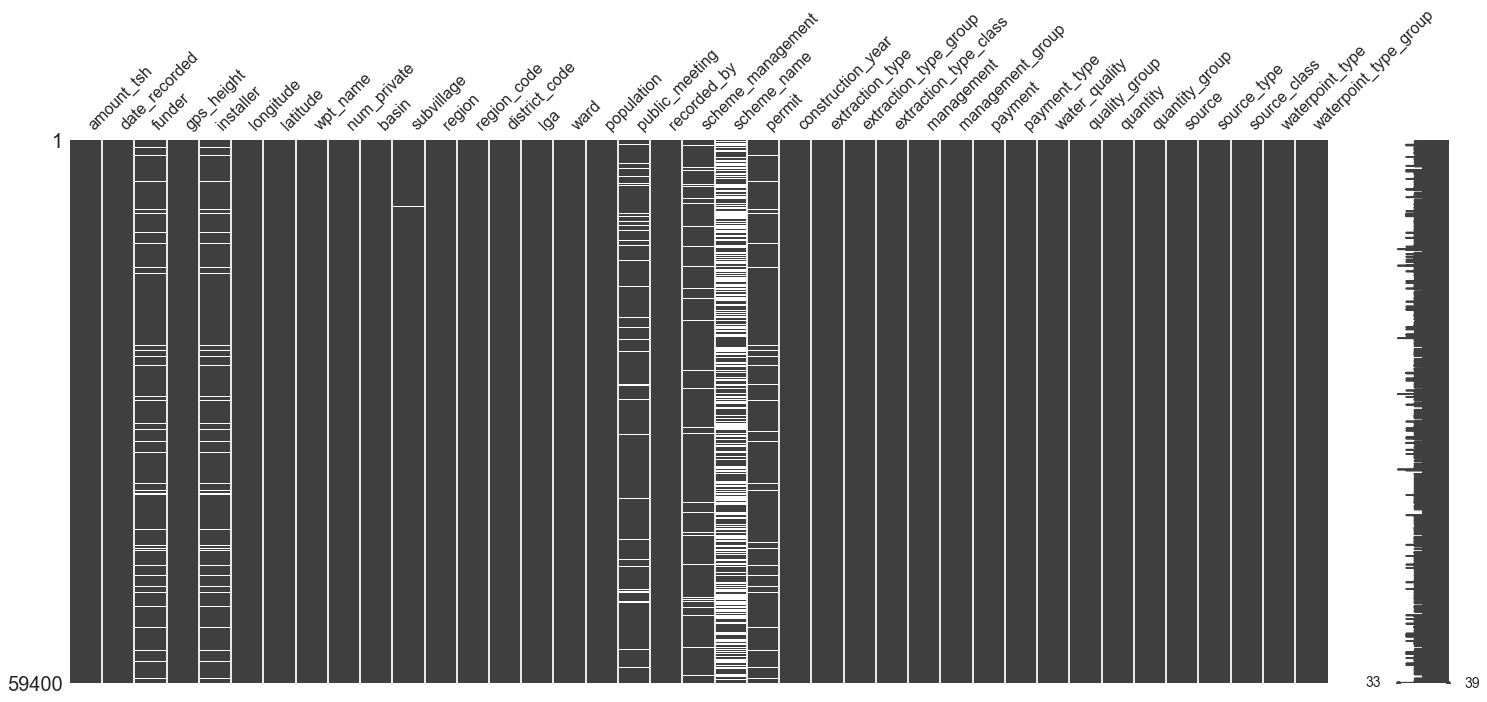

In [13]:
#visualize nulls
msno.matrix(data_values) 

> Looking at the matrix we can see that funder and installer have identical missing data in their rows. I will take care of these below.

In [14]:
#identify # of unique funders and how many pumps they funded
print('Data Value has {} unique Funders of pumps in Tanzania.'.format(len(data_values.funder.value_counts())))
data_values.funder.value_counts().head(50)

Data Value has 1897 unique Funders of pumps in Tanzania.


Government Of Tanzania            9084
Danida                            3114
Hesawa                            2202
Rwssp                             1374
World Bank                        1349
Kkkt                              1287
World Vision                      1246
Unicef                            1057
Tasaf                              877
District Council                   843
Dhv                                829
Private Individual                 826
Dwsp                               811
0                                  777
Norad                              765
Germany Republi                    610
Tcrs                               602
Ministry Of Water                  590
Water                              583
Dwe                                484
Netherlands                        470
Hifab                              450
Adb                                448
Lga                                442
Amref                              425
Fini Water               

In [15]:
#Identify quantity of nulls
data_values.funder.isna().sum()

3635

**OBSERVATIONS**:


3635 Null Values.

As well as...
- Not Known (27)
- Unknown (4)
- Missio (2) Is that a place? - Missions Group so leave it.
- None (2)
- 0 did 777 pumps, I am going to assume this means zero as in they do not know who inserted the pumps.

In [16]:
#fill null with Unknown
data_values.funder.fillna('Unknown', inplace = True)

#confirm it worked
data_values.funder.isna().sum()

0

In [17]:
#replace other placekeepers with Unknown as well
data_values.funder.replace(to_replace= ['Not Known', 'None', '0', 'NaN'], 
                           value= 'Unknown', inplace = True)

#final check on funder column
data_values.funder.value_counts().head(10)

Government Of Tanzania    9084
Unknown                   4445
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
Name: funder, dtype: int64

In [18]:
#identify # of installers 
print('Data Value has {} unique installers of pumps in Tanzania'.format(len(data_values.installer.value_counts())))

#display max rows
#pd.set_option('display.max_rows', None)
#data_values.installer.value_counts()

Data Value has 2145 unique installers of pumps in Tanzania


In [19]:
#check quantity of nulls
data_values.installer.isna().sum()

3655

**OBSERVATIONS**:

3655 Null Value which is slightly higher than the funder column.

As well as...
- 0 = 777
- Not known = 24
- not known = 17

In [20]:
#fill nulls with Unknown
data_values.installer.fillna('Unknown', inplace = True)

In [21]:
#fill other placekeepers with Unknown
data_values.installer.replace(to_replace= ['not known', 'Not known', 'None', 
                                           '0', 'NaN'], value= 'Unknown', 
                              inplace = True)

#Recheck Nulls
data_values.installer.isna().sum()

0

<AxesSubplot:>

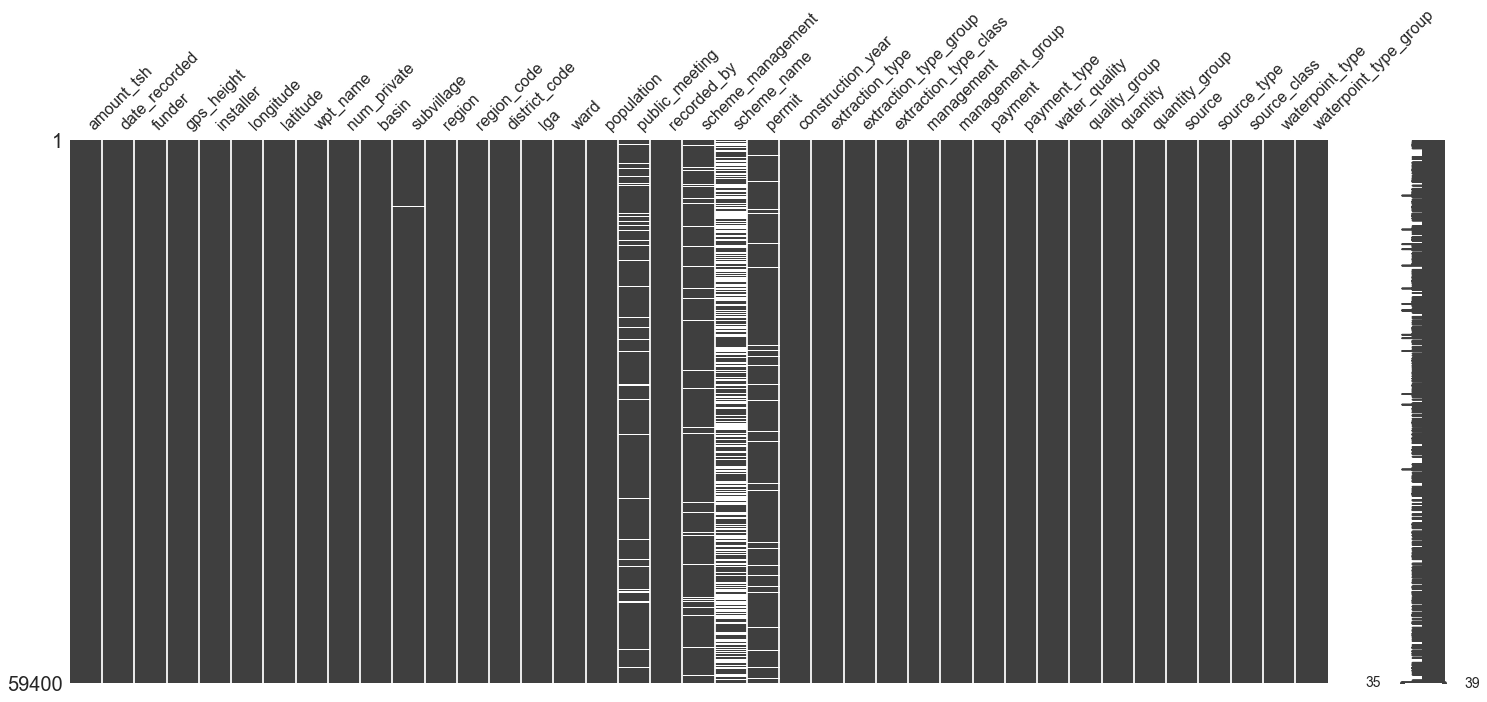

In [22]:
#revisualize nulls
msno.matrix(data_values) 

In [23]:
#scheme_name nulls
data_values.scheme_name.isna().value_counts()

False    31234
True     28166
Name: scheme_name, dtype: int64

In [24]:
#scheme_management nulls
data_values.scheme_management.isna().sum()

3877

>Scheme Management and Scheme Name are both described as "Who operates the waterpoint". Since there Scheme Name has over 28,000 Null values I will drop that column and keep Scheme Management in its place.

In [25]:
#drop scheme_name column
data_values = data_values.drop('scheme_name', axis = 1)
data_values.head()

amount_tsh date_recorded        funder  gps_height     installer  \
id                                                                        
69572      6000.0    2011-03-14         Roman        1390         Roman   
8776          0.0    2013-03-06       Grumeti        1399       GRUMETI   
34310        25.0    2013-02-25  Lottery Club         686  World vision   
67743         0.0    2013-01-28        Unicef         263        UNICEF   
19728         0.0    2011-07-13   Action In A           0       Artisan   

       longitude   latitude              wpt_name  num_private  \
id                                                               
69572  34.938093  -9.856322                  none            0   
8776   34.698766  -2.147466              Zahanati            0   
34310  37.460664  -3.821329           Kwa Mahundi            0   
67743  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
19728  31.130847  -1.825359               Shuleni            0   

                         basin  subvillage   region  region_code  \
id                                                                 
69572               Lake Nyasa    Mnyusi B   Iringa           11   
8776             Lake Victoria     Nyamara     Mara           20   
34310                  Pangani     Majengo  Manyara           21   
67743  Ruvuma / Southern Coast  Mahakamani   Mtwara           90   
19728            Lake Victoria  Kyanyamisa   Kagera           18   

       district_code        lga        ward  population public_meeting  \
id                                                                       
69572              5     Ludewa    Mundindi         109           True   
8776               2  Serengeti       Natta         280            NaN   
34310              4  Simanjiro     Ngorika         250           True   
67743             63   Nanyumbu    Nanyumbu          58           True   
19728              1    Karagwe  Nyakasimbi           0           True   

                   recorded_by scheme_management permit  construction_year  \
id                                                                           
69572  GeoData Consultants Ltd               VWC  False               1999   
8776   GeoData Consultants Ltd             Other   True               2010   
34310  GeoData Consultants Ltd               VWC   True               2009   
67743  GeoData Consultants Ltd               VWC   True               1986   
19728  GeoData Consultants Ltd               NaN   True                  0   

      extraction_type extraction_type_group extraction_type_class management  \
id                                                                             
69572         gravity               gravity               gravity        vwc   
8776          gravity               gravity               gravity        wug   
34310         gravity               gravity               gravity        vwc   
67743     submersible           submersible           submersible        vwc   
19728         gravity               gravity               gravity      other   

      management_group         payment payment_type water_quality  \
id                                                                  
69572       user-group    pay annually     annually          soft   
8776        user-group       never pay    never pay          soft   
34310       user-group  pay per bucket   per bucket          soft   
67743       user-group       never pay    never pay          soft   
19728            other       never pay    never pay          soft   

      quality_group      quantity quantity_group                source  \
id                                                                       
69572          good        enough         enough                spring   
8776           good  insufficient   insufficient  rainwater harvesting   
34310          good        enough         enough                   dam   
67743          good           dry            dry           m

## Diving Deeper into Specific Columns

**Dropping Waterpoint_type**

>Waterpoint_type and Waterpoint_type_group have the same information. Looking at their value counts below I can see that it is identical except that waterpoint_type_group has more information on communal standpipe. Therefore I will drop waterpoint_type from the data frame. 

In [26]:
data_values.waterpoint_type.value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [27]:
data_values.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [28]:
#drop waterpoint_type column
data_values = data_values.drop('waterpoint_type', axis = 1)

**Dropping Source_type and Source_class**

In [29]:
data_values.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [30]:
data_values.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [31]:
data_values.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

>These three columns have a lot in column. Upon first glance I can see that source_class is the least useful of the three because it only specifies groundwater vs surface water. The other two columns specify the type of ground water or surface water making them more detailed and useful. *Therefore I will definitely drop source_class.*

>Looking at source vs source_type these two are very similar. Source splits river and lake into two categories as well as adding hand dtw. Upon researching I can see that a borehole is basically a smaller well that is dug by a machine dbh. I will keep source and drop souce_type since it is less detailed.

In [32]:
#drop souce_class and source_type
data_values = data_values.drop(columns = ['source_class', 'source_type'], axis = 1)
data_values.head(50)

amount_tsh date_recorded                    funder  gps_height  \
id                                                                      
69572      6000.0    2011-03-14                     Roman        1390   
8776          0.0    2013-03-06                   Grumeti        1399   
34310        25.0    2013-02-25              Lottery Club         686   
67743         0.0    2013-01-28                    Unicef         263   
19728         0.0    2011-07-13               Action In A           0   
9944         20.0    2011-03-13       Mkinga Distric Coun           0   
19816         0.0    2012-10-01                      Dwsp           0   
54551         0.0    2012-10-09                     Rwssp           0   
53934         0.0    2012-11-03                  Wateraid           0   
46144         0.0    2011-08-03               Isingiro Ho           0   
49056         0.0    2011-02-20                   Private          62   
50409       200.0    2013-02-18                    Danida        1062   
36957         0.0    2012-10-14              World Vision           0   
50495         0.0    2013-03-15   Lawatefuka Water Supply        1368   
53752         0.0    2012-10-20                     Biore           0   
61848         0.0    2011-08-04                     Rudep        1645   
48451       500.0    2011-07-04                    Unicef        1703   
58155         0.0    2011-09-04                    Unicef        1656   
34169         0.0    2011-07-22                    Hesawa        1162   
18274       500.0    2011-02-22                    Danida        1763   
48375       200.0    2011-02-27                       Twe        2216   
6091          0.0    2013-02-10                      Dwsp           0   
58500         0.0    2011-10-04                    Unicef        1510   
37862       500.0    2013-11-03                       Isf         672   
51058         0.0    2013-01-21  African Development Bank        1645   
22308         0.0    2013-02-25    Government Of Tanzania        1273   
55012       500.0    2013-01-16                    Sobodo         200   
20145         0.0    2011-07-11                    Hesawa           0   
19685         0.0    2013-03-05    Government Of Tanzania        1443   
69124         0.0    2013-03-16   Lawatefuka Water Supply        1256   
46804         0.0    2011-03-23                     Water           0   
6696         50.0    2011-03-16        Private Individual         180   
57238         0.0    2013-03-19    Government Of Tanzania        1481   
12402         0.0    2011-03-11                      Undp        1638   
41583         0.0    2011-02-23                   Unknown         -41   
57355         0.0    2013-03-28                   Unknown        1546   
67359         0.0    2011-07-16                    Danida           0   
60048         0.0    2011-03-27                     Kirde           0   
16583      4000.0    2011-02-20                      Cefa        1955   
25            0.0    2013-02-11    Government Of Tanzania        1348   
70238        25.0    2013-10-03                 Ces(gmbh)         710   
12796       500.0    2011-03-12    Government Of Tanzania        2469   
52019       500.0    2011-07-07            European Union        1803   
19282         0.0    2013-01-15                   Unknown        1642   
1843         20.0    2013-03-18    Government Of Tanzania        1007   
12958         0.0    2012-10-22              World Vision           0   
45111        20.0    2013-02-05                       Lga         240   
13620         0.0    2011-07-27                   Unknown           0   
18864      4000.0    2011-02-20                      Cefa        1982   
25182      1500.0    2011-04-04          District Council        2169   

                  installer  longitude      latitude                wpt_name  \
id                                                                             
69572                 Roman  34.938093 -9.856322e+

**Drop quantity_group**

In [33]:
data_values.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [34]:
data_values.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

>These two columns have the exact same information. I will drop quantity_group as I do not need repeated information.

In [35]:
#drop quantity_group
data_values = data_values.drop('quantity_group', axis = 1)

**Dropping quality_group**

In [36]:
data_values.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [37]:
data_values.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

Upon doing research **abandoned** can mean one of two things: 
1. Well was abandoned and is no longer in use - if so the well needs to be plugged or restored to its original hydrogelogical condition in order to prevent pollution and possible complications from mixing with other aquifiers.
2. Well is no longer being taken care of - this would mean it can be unsafe for the population to drink from.

**I will drop quality_group since the term abandoned carries important information**

In [38]:
#Drop quality_group
data_values = data_values.drop('quality_group', axis = 1)

**Dropping Payment**

In [39]:
data_values.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [40]:
data_values.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

>These two columns have the exact same information. I will drop payment in order to keep only one column.

In [41]:
#drop payment column
data_values = data_values.drop('payment', axis = 1)

**Drop Date Recorded**

Will not be using date recorded in my models.

In [42]:
data_values = data_values.drop('date_recorded', axis = 1)

**Management**

In [43]:
data_values.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [44]:
data_values.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

>For now I am going to keep both of these groups. Management_group states if the well is taken care of by commerce, the people actually using the well, or a political group. This may be interesting to look at later. Then the management column takes the groups and divides them into smaller groups. I could see later that a specific user-group is not taking care of the wells and we could target that subgroup more.

**Dropping Extraction_type_group and extraction_type_class**

In [45]:
data_values.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [46]:
data_values.extraction_type_group.value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [47]:
data_values.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

>These three columns all answer the question "what kind of extraction the waterpoint uses" to varying degrees. I am going to keep the column extraction_type because it is the most specific.

In [48]:
#drop extraction_type_class and group
data_values = data_values.drop(columns = ['extraction_type_class',
                                          'extraction_type_group'], axis = 1)

**Construction year**

In [49]:
data_values.construction_year.value_counts().sort_index()

0       20709
1960      102
1961       21
1962       30
1963       85
1964       40
1965       19
1966       17
1967       88
1968       77
1969       59
1970      411
1971      145
1972      708
1973      184
1974      676
1975      437
1976      414
1977      202
1978     1037
1979      192
1980      811
1981      238
1982      744
1983      488
1984      779
1985      945
1986      434
1987      302
1988      521
1989      316
1990      954
1991      324
1992      640
1993      608
1994      738
1995     1014
1996      811
1997      644
1998      966
1999      979
2000     2091
2001      540
2002     1075
2003     1286
2004     1123
2005     1011
2006     1471
2007     1587
2008     2613
2009     2533
2010     2645
2011     1256
2012     1084
2013      176
Name: construction_year, dtype: int64

>Looking at construction year there are 20,709 rows that do not have their construction year identified. I am going to assume that these pumps were built before those with valid data and assign the year 1959 to any marked 0.

In [50]:
#replace 0 with 1959
data_values.construction_year.replace(0, 1959, inplace=True)

In [51]:
#recheck value counts
data_values.construction_year.value_counts().sort_index()

1959    20709
1960      102
1961       21
1962       30
1963       85
1964       40
1965       19
1966       17
1967       88
1968       77
1969       59
1970      411
1971      145
1972      708
1973      184
1974      676
1975      437
1976      414
1977      202
1978     1037
1979      192
1980      811
1981      238
1982      744
1983      488
1984      779
1985      945
1986      434
1987      302
1988      521
1989      316
1990      954
1991      324
1992      640
1993      608
1994      738
1995     1014
1996      811
1997      644
1998      966
1999      979
2000     2091
2001      540
2002     1075
2003     1286
2004     1123
2005     1011
2006     1471
2007     1587
2008     2613
2009     2533
2010     2645
2011     1256
2012     1084
2013      176
Name: construction_year, dtype: int64

**Scheme**

In [52]:
data_values.recorded_by.value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

>All data was entered by GeoData Consultants Ltd. I will keep this information here and delete this row from my data.

In [53]:
data_values = data_values.drop('recorded_by', axis = 1)

**Public Meeting**

In [54]:
#public meeting nulls
data_values.public_meeting.isna().sum()

3334

In [55]:
data_values.public_meeting.value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [56]:
#fill nulls with True
data_values.public_meeting.fillna(True, inplace=True)

> Fill Null Values in Public Meeting with the majority which is True. Assume the well is in a public place.

**Population**

In [57]:
data_values.population.value_counts().sort_index(ascending = True)

0        21381
1         7025
2            4
3            4
4           13
         ...  
9865         1
10000        3
11463        1
15300        1
30500        1
Name: population, Length: 1049, dtype: int64

In [58]:
#replace 0 with the median population
data_values.replace(0, (data_values.population.median()), inplace = True)

> Replace 0 with the median population for each well

**Geographic Location**

In [59]:
#administrative division of a city 
data_values.ward.value_counts().head(20)

Igosi            307
Imalinyi         252
Siha Kati        232
Mdandu           231
Nduruma          217
Kitunda          203
Mishamo          203
Msindo           201
Chalinze         196
Maji ya Chai     190
Usuka            187
Ngarenanyuki     172
Chanika          171
Vikindu          162
Mtwango          153
Matola           145
Zinga/Ikerege    141
Maramba          139
Wanging'ombe     139
Itete            137
Name: ward, dtype: int64

In [60]:
#specific village
data_values.subvillage.value_counts().head()

Madukani    508
Shuleni     506
Majengo     502
Kati        373
Mtakuja     262
Name: subvillage, dtype: int64

In [61]:
#region of Tanzania
data_values.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [62]:
#drop region code & use word instead
data_values.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [63]:
#drop district code & word instead
data_values.district_code.value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
25       23
80       12
67        6
Name: district_code, dtype: int64

In [64]:
#drop region and district codes
data_values.drop(columns = ['region_code', 'district_code'], axis = 1, 
                 inplace = True)

In [65]:
#lga means local gov authority
data_values.lga.value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

#### num_private

In [66]:
data_values.num_private.value_counts()

25     58655
6         81
1         73
5         46
8         46
       ...  
280        1
141        1
62         1
111        1
94         1
Name: num_private, Length: 64, dtype: int64

>We have no information on what num_private is. Consider dropping. May keep for now to see if it plays a factor later.

**Take care of remaining Nulls**

In [67]:
data_values.isna().sum()

amount_tsh                  0
funder                      0
gps_height                  0
installer                   0
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                371
region                      0
lga                         0
ward                        0
population                  0
public_meeting              0
scheme_management        3877
permit                   3056
construction_year           0
extraction_type             0
management                  0
management_group            0
payment_type                0
water_quality               0
quantity                    0
source                      0
waterpoint_type_group       0
dtype: int64

In [68]:
data_values.dtypes

amount_tsh               float64
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
lga                       object
ward                      object
population                 int64
public_meeting              bool
scheme_management         object
permit                    object
construction_year          int64
extraction_type           object
management                object
management_group          object
payment_type              object
water_quality             object
quantity                  object
source                    object
waterpoint_type_group     object
dtype: object

In [69]:
#replace nulls with Unknown
data_values.subvillage.fillna('Unknown', inplace = True)

In [70]:
#replace nulls with Unknown
data_values.scheme_management.fillna('Unknown', inplace = True)
data_values.permit.value_counts()

True    38852
25.0    17492
Name: permit, dtype: int64

>Assume 25 means no permit? Replace nulls and the number 25 with False.

In [71]:
data_values.permit.replace(25.0, 'False', inplace = True)

In [72]:
data_values.fillna('False', inplace = True)
data_values.isna().sum()

amount_tsh               0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
management               0
management_group         0
payment_type             0
water_quality            0
quantity                 0
source                   0
waterpoint_type_group    0
dtype: int64

In [73]:
print(data_values.shape)
data_values.head()

(59400, 26)


amount_tsh        funder  gps_height     installer  longitude  \
id                                                                     
69572      6000.0         Roman        1390         Roman  34.938093   
8776         25.0       Grumeti        1399       GRUMETI  34.698766   
34310        25.0  Lottery Club         686  World vision  37.460664   
67743        25.0        Unicef         263        UNICEF  38.486161   
19728        25.0   Action In A          25       Artisan  31.130847   

        latitude              wpt_name  num_private                    basin  \
id                                                                             
69572  -9.856322                  none           25               Lake Nyasa   
8776   -2.147466              Zahanati           25            Lake Victoria   
34310  -3.821329           Kwa Mahundi           25                  Pangani   
67743 -11.155298  Zahanati Ya Nanyumbu           25  Ruvuma / Southern Coast   
19728  -1.825359               Shuleni           25            Lake Victoria   

       subvillage   region        lga        ward  population  public_meeting  \
id                                                                              
69572    Mnyusi B   Iringa     Ludewa    Mundindi         109            True   
8776      Nyamara     Mara  Serengeti       Natta         280            True   
34310     Majengo  Manyara  Simanjiro     Ngorika         250            True   
67743  Mahakamani   Mtwara   Nanyumbu    Nanyumbu          58            True   
19728  Kyanyamisa   Kagera    Karagwe  Nyakasimbi          25            True   

      scheme_management permit  construction_year extraction_type management  \
id                                                                             
69572               VWC  False               1999         gravity        vwc   
8776              Other   True               2010         gravity        wug   
34310               VWC   True               2009         gravity        vwc   
67743               VWC   True               1986     submersible        vwc   
19728           Unknown   True               1959         gravity      other   

      management_group payment_type water_quality      quantity  \
id                                                                
69572       user-group     annually          soft        enough   
8776        user-group    never pay          soft  insufficient   
34310       user-group   per bucket          soft        enough   
67743       user-group    never pay          soft           dry   
19728            other    never pay          soft      seasonal   

                     source waterpoint_type_group  
id                                                 
69572                spring    communal standpipe  
8776   rainwater harvesting    communal standpipe  
34310                   dam    communal standpipe  
67743           machine dbh    communal standpipe  
19728  rainwater harvesting    communal standpipe

**Final Scrub Check**

In [74]:
data_values.describe()

amount_tsh    gps_height     longitude      latitude   num_private  \
count   59400.000000  59400.000000  59400.000000  5.940000e+04  59400.000000   
mean      335.175216    676.899091     34.840053 -5.706033e+00     25.155539   
std      2995.738725    684.875135      3.104509  2.946019e+00     11.583768   
min         0.200000    -90.000000     25.000000 -1.164944e+01      1.000000   
25%        25.000000     25.000000     33.090347 -8.540621e+00     25.000000   
50%        25.000000    369.000000     34.908743 -5.021597e+00     25.000000   
75%        25.000000   1319.250000     37.178387 -3.326156e+00     25.000000   
max    350000.000000   2770.000000     40.345193 -2.000000e-08   1776.000000   

         population  construction_year  
count  59400.000000       59400.000000  
mean     188.908721        1983.631111  
std      468.189551          20.641015  
min        1.000000        1959.000000  
25%       25.000000        1959.000000  
50%       25.000000        1986.000000  
75%      215.000000        2004.000000  
max    30500.000000        2013.000000

# Explore

In [75]:
#set_style
plt.style.use('seaborn-poster')

#set color palette for visualizations
sns.set_palette("Blues")

## Visualizations

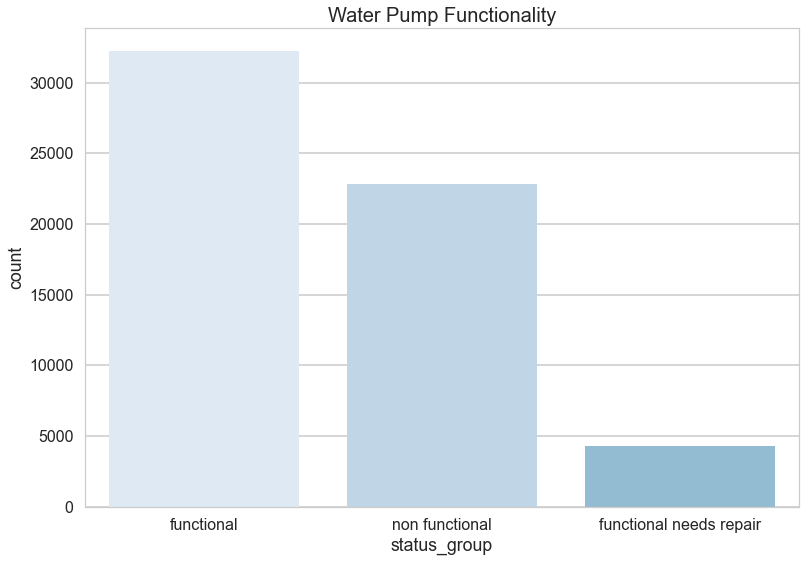

In [76]:
#visualize water pump functionality
ax = sns.countplot(x= "status_group", data=data_labels);
ax.set_title("Water Pump Functionality", fontsize = 20);

> It looks like the majority of wells are functional, but the center column shows a high amount of non-functional wells that need to be addressed.

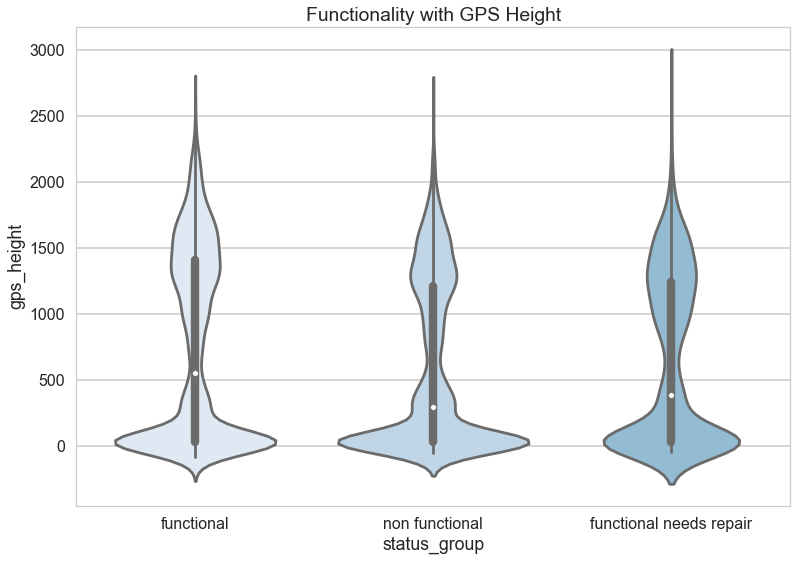

In [77]:
#comparison with gps height
sns.violinplot(x = data_labels.status_group, y= data_values.gps_height).set_title(
    "Functionality with GPS Height");

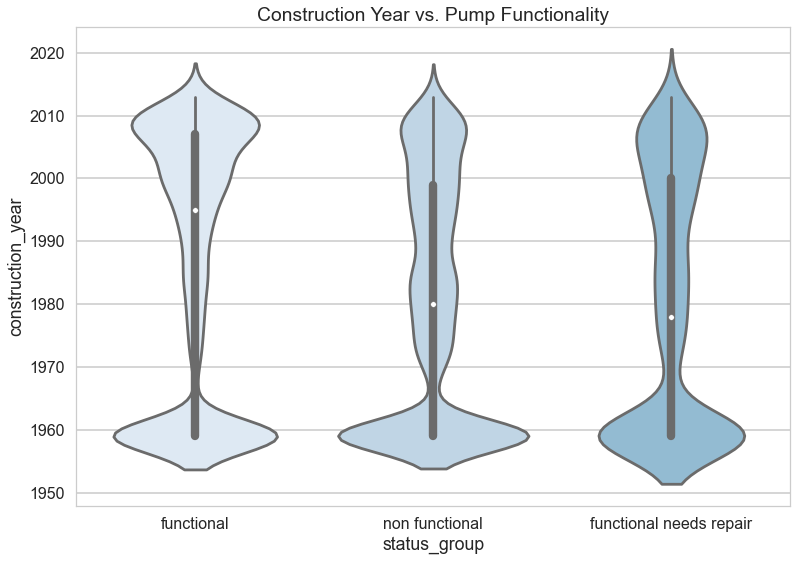

In [78]:
#violin plot with construction year
sns.violinplot(x = data_labels.status_group, y= data_values.construction_year).set_title("Construction Year vs. Pump Functionality");

>We can see that wells marked before 1965 are in need of attention. Since I switched any pump marked zero as 1959 it might be a recommendation to have them inspect any pump where construction year is not labeled.

In [79]:
%%HTML 
<div class='tableauPlaceholder' id='viz1601559908930' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Fu&#47;FunctionalityofWaterPumpsUsingLatitudeandLongitude&#47;Sheet1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='FunctionalityofWaterPumpsUsingLatitudeandLongitude&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Fu&#47;FunctionalityofWaterPumpsUsingLatitudeandLongitude&#47;Sheet1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1601559908930');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

<div class="alert alert-block alert-info">
The above map is interactive. Feel free to select which status groups you would like to see. You may select one, two, or all. 

## Dealing with Categoricals

In [80]:
#drop columns
data_values = data_values.drop(columns = ['funder', 'wpt_name', 'subvillage', 'lga',
                                 'ward', 'management_group', 'scheme_management'])

In [81]:
#list of categorial columns
cat_col = data_values.select_dtypes('O').columns
cat_col

Index(['installer', 'basin', 'region', 'permit', 'extraction_type',
       'management', 'payment_type', 'water_quality', 'quantity', 'source',
       'waterpoint_type_group'],
      dtype='object')

In [82]:
#quantity of unique installers
data_values.installer.value_counts()

DWE                  17402
Unknown               4476
Government            1825
RWE                   1206
Commu                 1060
                     ...  
Masele Nzengula          1
KOYI                     1
Adam Kea                 1
DV                       1
Centra Government        1
Name: installer, Length: 2142, dtype: int64

<div class="alert alert-block alert-warning">
  Installer is important but I cannot get dummies all of these into separate columns. I will make the cut off 1000 and merge the remainder into Unknown. 

**In the cell below I took care of the quantity of unique values before one hot encoding. To do this I selected the Object columns and kept any unique values with over 1000. For the remainder of the data I grouped it into a new group labeled *Infrequent* as there were many installers that only worked on a couple of wells.**

In [83]:
cols = data_values.select_dtypes('O').columns
data_values[cols] = data_values[cols].where(
    data_values[cols].apply(lambda x: x.map(x.value_counts())) >=1000,
    "Infrequent")
data_values.nunique()

amount_tsh                  97
gps_height                2427
installer                    7
longitude                57516
latitude                 57517
num_private                 64
basin                        9
region                      21
population                1048
public_meeting               2
permit                       2
construction_year           55
extraction_type             10
management                   7
payment_type                 7
water_quality                4
quantity                     5
source                       6
waterpoint_type_group        4
dtype: int64

In [84]:
data_values.isna().sum()

amount_tsh               0
gps_height               0
installer                0
longitude                0
latitude                 0
num_private              0
basin                    0
region                   0
population               0
public_meeting           0
permit                   0
construction_year        0
extraction_type          0
management               0
payment_type             0
water_quality            0
quantity                 0
source                   0
waterpoint_type_group    0
dtype: int64

In [85]:
#pull all objects into cat_cols
cat_cols = data_values.select_dtypes('O').columns

#check
data_values[cat_cols].dtypes

installer                object
basin                    object
region                   object
permit                   object
extraction_type          object
management               object
payment_type             object
water_quality            object
quantity                 object
source                   object
waterpoint_type_group    object
dtype: object

In [86]:
data_values[cat_cols].head()

installer                    basin   region permit extraction_type  \
id                                                                           
69572  Infrequent               Lake Nyasa   Iringa  False         gravity   
8776   Infrequent            Lake Victoria     Mara   True         gravity   
34310  Infrequent                  Pangani  Manyara   True         gravity   
67743  Infrequent  Ruvuma / Southern Coast   Mtwara   True     submersible   
19728  Infrequent            Lake Victoria   Kagera   True         gravity   

       management payment_type water_quality      quantity  \
id                                                           
69572         vwc     annually          soft        enough   
8776          wug    never pay          soft  insufficient   
34310         vwc   per bucket          soft        enough   
67743         vwc    never pay          soft           dry   
19728  Infrequent    never pay          soft      seasonal   

                     source waterpoint_type_group  
id                                                 
69572                spring    communal standpipe  
8776   rainwater harvesting    communal standpipe  
34310            Infrequent    communal standpipe  
67743           machine dbh    communal standpipe  
19728  rainwater harvesting    communal standpipe

In [87]:
pd.get_dummies(data_values.installer).head()

Commu  DANIDA  DWE  Government  Infrequent  RWE  Unknown
id                                                             
69572      0       0    0           0           1    0        0
8776       0       0    0           0           1    0        0
34310      0       0    0           0           1    0        0
67743      0       0    0           0           1    0        0
19728      0       0    0           0           1    0        0

In [88]:
#create new df with cat and num
encoded_cat = pd.get_dummies(data_values, columns = cat_cols)
encoded_cat.head()

amount_tsh  gps_height  longitude   latitude  num_private  population  \
id                                                                             
69572      6000.0        1390  34.938093  -9.856322           25         109   
8776         25.0        1399  34.698766  -2.147466           25         280   
34310        25.0         686  37.460664  -3.821329           25         250   
67743        25.0         263  38.486161 -11.155298           25          58   
19728        25.0          25  31.130847  -1.825359           25          25   

       public_meeting  construction_year  installer_Commu  installer_DANIDA  \
id                                                                            
69572            True               1999                0                 0   
8776             True               2010                0                 0   
34310            True               2009                0                 0   
67743            True               1986                0                 0   
19728            True               1959                0                 0   

       installer_DWE  installer_Government  installer_Infrequent  \
id                                                                 
69572              0                     0                     1   
8776               0                     0                     1   
34310              0                     0                     1   
67743              0                     0                     1   
19728              0                     0                     1   

       installer_RWE  installer_Unknown  basin_Internal  basin_Lake Nyasa  \
id                                                                          
69572              0                  0               0                 1   
8776               0                  0               0                 0   
34310              0                  0               0                 0   
67743              0                  0               0                 0   
19728              0                  0               0                 0   

       basin_Lake Rukwa  basin_Lake Tanganyika  basin_Lake Victoria  \
id                                                                    
69572                 0                      0                    0   
8776                  0                      0                    1   
34310                 0                      0                    0   
67743                 0                      0                    0   
19728                 0                      0                    1   

       basin_Pangani  basin_Rufiji  basin_Ruvuma / Southern Coast  \
id                                                                  
69572              0             0                              0   
8776               0             0                              0   
34310              1             0                              0   
67743              0             0                              1   
19728              0             0                              0   

       basin_Wami / Ruvu  region_Arusha  region_Dodoma  region_Infrequent  \
id                                                                          
69572                  0              0              0                  0   
8776                   0              0              0                  0   
34310                  0              0              0                  0   
67743                  0              0              0                  0   
19728                  0              0              0                  0   

       region_Iringa  region_Kagera  region_Kigoma  region_Kilimanjaro  \
id                                                                       
69572              1              0              0                   0   
8776               0              0              0                   0   
34310              0              0              0       

In [89]:
data_frame = encoded_cat.copy()

## Train Test Split

In [90]:
#assign X and y
y = data_labels.status_group
X = data_frame

In [91]:
#perform label encoding on y

lb_make = LabelEncoder()
y_encoded = lb_make.fit_transform(y)
y_encoded = pd.Series(y_encoded, index = y.index)

In [92]:
y_encoded.value_counts(normalize=True)

0    0.543081
2    0.384242
1    0.072677
dtype: float64

In [93]:
#ensure I know labels correctly
lb_make.inverse_transform([0, 1, 2])

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

In [94]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(44550, 90) (44550,)
(14850, 90) (14850,)


In [95]:
y_train.value_counts(1), y_test.value_counts(1)

(0    0.542334
 2    0.384871
 1    0.072795
 dtype: float64, 0    0.545320
 2    0.382357
 1    0.072323
 dtype: float64)

In [96]:
X_train.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'population', 'public_meeting', 'construction_year', 'installer_Commu',
       'installer_DANIDA', 'installer_DWE', 'installer_Government',
       'installer_Infrequent', 'installer_RWE', 'installer_Unknown',
       'basin_Internal', 'basin_Lake Nyasa', 'basin_Lake Rukwa',
       'basin_Lake Tanganyika', 'basin_Lake Victoria', 'basin_Pangani',
       'basin_Rufiji', 'basin_Ruvuma / Southern Coast', 'basin_Wami / Ruvu',
       'region_Arusha', 'region_Dodoma', 'region_Infrequent', 'region_Iringa',
       'region_Kagera', 'region_Kigoma', 'region_Kilimanjaro', 'region_Lindi',
       'region_Manyara', 'region_Mara', 'region_Mbeya', 'region_Morogoro',
       'region_Mtwara', 'region_Mwanza', 'region_Pwani', 'region_Rukwa',
       'region_Ruvuma', 'region_Shinyanga', 'region_Singida', 'region_Tabora',
       'region_Tanga', 'permit_True', 'permit_False',
       'extraction_type_Infrequent', 'extraction_type_af

# Model

### Decision Tree

Used to classify by partitioning the sample space as efficiently as possible into sets with similar data points until you get close to a homogenous set and can reasonably predict the value for new data points. 

<img src="https://21fhr94db5shqg1rg20j8erj-wpengine.netdna-ssl.com/wp-content/uploads/2019/12/Decision-Trees-2.png"/>
image from explorium.ai/blog

#### Decision Tree Vanilla

In [97]:
#instantiate vanilla decision tree
tree_clf = DecisionTreeClassifier()

#fit decision tree
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [98]:
#test set predictions
predict = tree_clf.predict(X_test)

#print conf matrix & class report
print(confusion_matrix(y_test, predict))
print(classification_report(y_test, predict))

[[6443  501 1154]
 [ 480  406  188]
 [1153  224 4301]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      8098
           1       0.36      0.38      0.37      1074
           2       0.76      0.76      0.76      5678

    accuracy                           0.75     14850
   macro avg       0.64      0.64      0.64     14850
weighted avg       0.75      0.75      0.75     14850



In [99]:
def model_information(clf, X_test, y_test):
    ''' Model information is used to create a classification report, 
    confusion matrix, roc curve, and when needed a feature importance
    visualization. 
    
    Args:
       clf: model used
       X_test: x test
       y_test: y test
       
    Returns:
        Classification Report
        Confusion Matrix
        ROC Curve
        Feature Importance
        
    Example: model_information(decision_tree, X_test, y_test)'''

    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)
    print("Testing Accuracy for Classifier: {:.4}%".format(
    accuracy_score(y_test, predict) * 100))
    print('---' * 20)

    #classification report
    print('CLASSIFICATION REPORT')
    print('---' * 20)
    print(classification_report(y_test, predict, target_names
                                = ["Functional", "Functional, needs repair", 
                                   "Not functional"]))
    
    print('---' * 20)
    with plt.style.context('seaborn-notebook'):
        fig, axes = plt.subplots(figsize = (8,8), nrows = 2)
        sns.set_palette("Blues")

        #confusion matrix
        conf = plot_confusion_matrix(clf, X_test, y_test, cmap = plt.cm.Blues, 
                                     display_labels = ["Functional",
                                                       "Functional, needs repair",
                                                       "Not functional"], ax=axes[0],
                                    normalize = 'true');
        conf.ax_.set_title('CONFUSION MATRIX');

        #roc curve need to use Yellow Brick
        visualizer = ROCAUC(clf, classes=["Functional", 
                                               "Functional, needs repair", 
                                               "Not functional"], ax=axes[1])

        visualizer.fit(X_train, y_train)        
        visualizer.score(X_test, y_test) 
        axes[1].plot([0,1],[0,1],ls=':')
        axes[1].grid()
        axes[1].set_title('ROC CURVE')
        fig.tight_layout()
        visualizer.show()

        #adding feature importance 
        try:
            print('---' *20)
            #print('FEATURE IMPORTANCE')
            #feature importance
            feat_import = pd.Series(clf.feature_importances_,index=X_train.columns)
            feat_import.sort_values().tail(20).plot(kind='barh').set_title('FEATURE IMPORTANCE')
        except:
            pass

Testing Accuracy for Classifier: 75.1%
------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
                          precision    recall  f1-score   support

              Functional       0.80      0.79      0.80      8098
Functional, needs repair       0.36      0.38      0.37      1074
          Not functional       0.76      0.76      0.76      5678

                accuracy                           0.75     14850
               macro avg       0.64      0.65      0.64     14850
            weighted avg       0.75      0.75      0.75     14850

------------------------------------------------------------


/Users/laurenesser/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


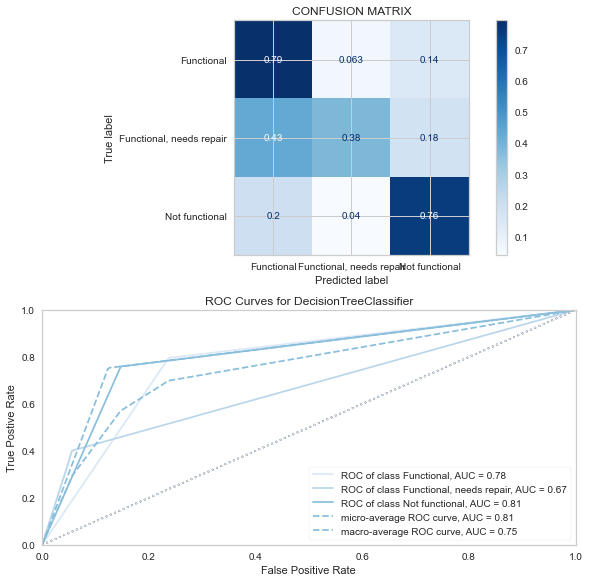

------------------------------------------------------------


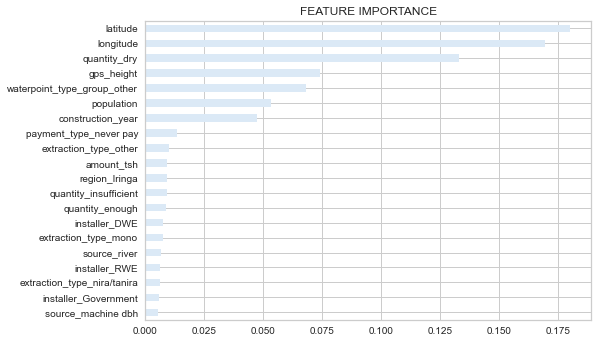

In [100]:
model_information(tree_clf, X_test, y_test)

<div class="alert alert-block alert-info">

>Model is not balanced.

---

**Precision**: How often is the prediction actually correct? (True positives / (True positives + False Positives))
- Looking act macro average (averaging the unweighted mean per label) we have a 62% precision.
---

**Recall**: How often does it predict correctly? (True Positives / (True Positives + False Negatives))
- Macro average is 63%.
---

**Accuracy**: Sum of correct predictions(true positives and true negatives) divided by total number of samples.
- 74%
---

**Top Feature Importance**: lat, long, quantity_dry, id, waterpoint_type_group, gps height, population, construction year.

---

**Macro-Average ROC Curve, AUC**: Tells how much model is capable of distinguishing between classes. 
- 74%



#### GridSearch CV Decision Tree


In [101]:
#adjusted tree_clf many times for best results
tree_clf_cv = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [90, 100],
    'min_samples_split': [2, 3],
    'class_weight': ['balanced']
}

gs_tree = GridSearchCV(tree_clf_cv, param_grid, cv = 3)
gs_tree.fit(X_train, y_train)
print(f"Training Accuracy: {gs_tree.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {gs_tree.best_params_}")

Training Accuracy: 74.49%

Optimal Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 2}


In [102]:
#Instantiate Decision Tree Classifier
tree_clf_cv = DecisionTreeClassifier(criterion= 'entropy', max_depth= 100, 
                                     min_samples_split= 2, class_weight = 'balanced' )


Testing Accuracy for Classifier: 75.33%
------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
                          precision    recall  f1-score   support

              Functional       0.80      0.79      0.80      8098
Functional, needs repair       0.36      0.40      0.38      1074
          Not functional       0.77      0.76      0.76      5678

                accuracy                           0.75     14850
               macro avg       0.64      0.65      0.65     14850
            weighted avg       0.76      0.75      0.75     14850

------------------------------------------------------------


/Users/laurenesser/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


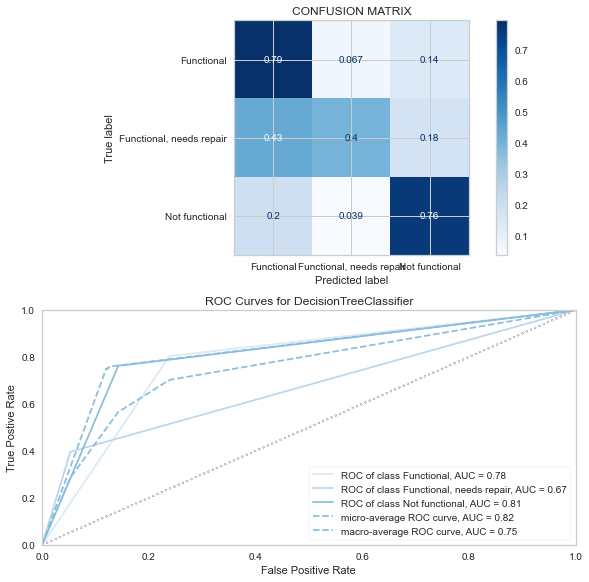

------------------------------------------------------------


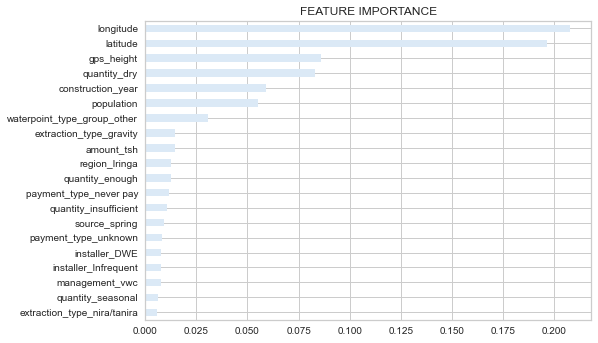

In [103]:
model_information(tree_clf_cv, X_test, y_test)

<div class="alert alert-block alert-info">

>Model is balanced.

---

**Precision**: How often is the prediction actually correct?
- 63%

---

**Recall**: How often does it predict correctly?
- 63%

---

**Accuracy**: Sum of true positives and true negatives divided by total number of samples.
- 74%

---

**Top Feature Importance**: Longitude, Latitude, Quantity_dry, gps_height, and construction year are top factors that impact if the well is functional.

---

**Macro-Average ROC Curve, AUC**: Tells how much model is capable of distinguishing between classes. 
- 74%


### Bagged Trees

<img src="https://i.stack.imgur.com/sYR7y.png"> Image taken from Stack Exchange

In [104]:
#instantiate bagged tree classifier
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion= 'entropy', max_depth= 100, 
                                     min_samples_split= 2, class_weight = 'balanced' ))


Testing Accuracy for Classifier: 78.79%
------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
                          precision    recall  f1-score   support

              Functional       0.80      0.87      0.83      8098
Functional, needs repair       0.43      0.34      0.38      1074
          Not functional       0.83      0.76      0.79      5678

                accuracy                           0.79     14850
               macro avg       0.69      0.65      0.67     14850
            weighted avg       0.78      0.79      0.78     14850

------------------------------------------------------------


/Users/laurenesser/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


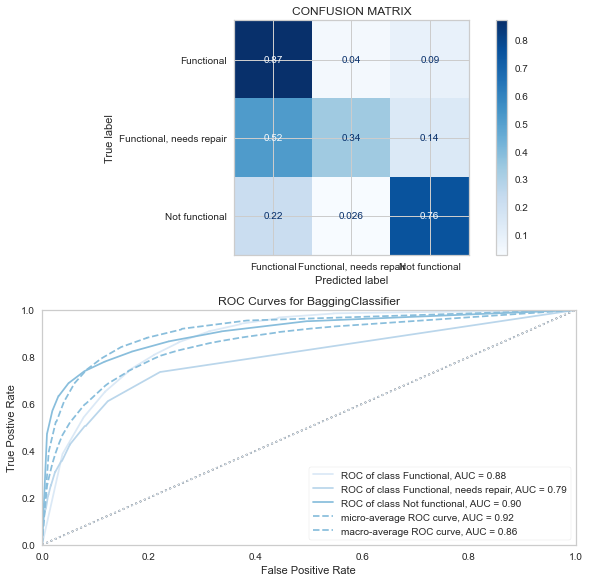

------------------------------------------------------------


In [105]:
#run model w/o feat importance
model_information(bagged_tree, X_test, y_test)

<div class="alert alert-block alert-info">

**Precision**: How often is the prediction actually correct?
- 68%

---

**Recall**: How often does it predict correctly?
- 64%

---

**Accuracy**: Sum of true positives and true negatives divided by total number of samples.
- 78%

---

**Macro-Average ROC Curve, AUC**: Tells how much model is capable of distinguishing between classes. 
- 86%

### Naive Bayes

#### Naive Bayes Vanilla

In [106]:
nb = GaussianNB()

Testing Accuracy for Classifier: 54.36%
------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
                          precision    recall  f1-score   support

              Functional       0.74      0.51      0.60      8098
Functional, needs repair       0.14      0.64      0.23      1074
          Not functional       0.72      0.58      0.64      5678

                accuracy                           0.54     14850
               macro avg       0.54      0.57      0.49     14850
            weighted avg       0.69      0.54      0.59     14850

------------------------------------------------------------


/Users/laurenesser/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


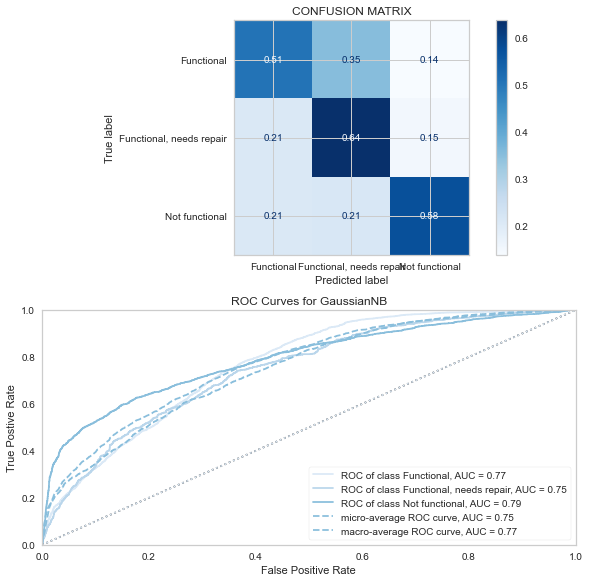

------------------------------------------------------------


In [107]:
model_information(nb, X_test, y_test)

<div class="alert alert-block alert-info">

**Precision**: How often is the prediction actually correct?
- 49%

---

**Recall**: How often does it predict correctly?
- 51%

---

**Accuracy**: Sum of true positives and true negatives divided by total number of samples.
- 55%

---

**Macro-Average ROC Curve, AUC**: Tells how much model is capable of distinguishing between classes. 
- 72%

### Random Forests

<img src ="https://dataaspirant.com/wp-content/uploads/2017/04/Random-Forest-Introduction.jpg"> From dataaspirant.com

#### Random Forest Vanilla

In [108]:
#instantiate and fit rf
rf = RandomForestClassifier()

Testing Accuracy for Classifier: 79.87%
------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
                          precision    recall  f1-score   support

              Functional       0.81      0.87      0.84      8098
Functional, needs repair       0.50      0.35      0.41      1074
          Not functional       0.83      0.78      0.80      5678

                accuracy                           0.80     14850
               macro avg       0.71      0.67      0.68     14850
            weighted avg       0.79      0.80      0.79     14850

------------------------------------------------------------


/Users/laurenesser/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


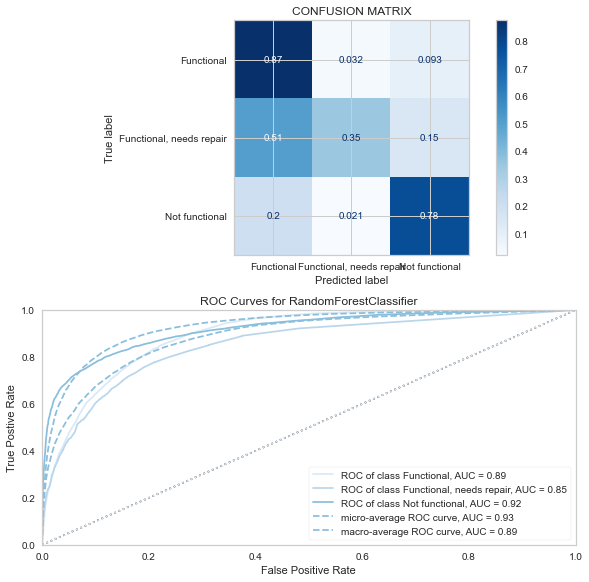

------------------------------------------------------------


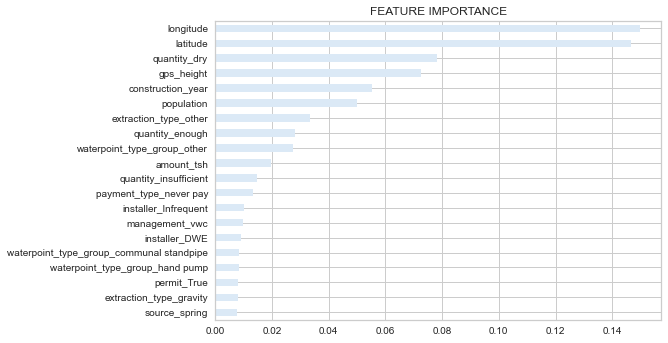

In [109]:
model_information(rf, X_test, y_test)

<div class="alert alert-block alert-info">

>Model is not balanced.

---

**Precision**: How often is the prediction actually correct?
- 71%

---

**Recall**: How often does it predict correctly?
- 66%

---

**Accuracy**: Sum of true positives and true negatives divided by total number of samples.
- 80%

---

**Top Feature Importance**: Longitude, Latitude, Quantity_dry, gps_height, and construction year are top factors that impact if the well is functional.

---

**Macro-Average ROC Curve, AUC**: Tells how much model is capable of distinguishing between classes. 
- 89%

#### GridSearchCV Random Forest

In [110]:
#set params to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [65, 70],
    'min_samples_split': [2, 3, 4],
    'class_weight': ['balanced']
}

gs_rf = GridSearchCV(rf, param_grid, cv = 3)
gs_rf.fit(X_train, y_train)
print(f"Training Accuracy: {gs_rf.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {gs_rf.best_params_}")

Training Accuracy: 79.45%

Optimal Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 65, 'min_samples_split': 2}


In [111]:
#instantiate rf classifier
rf = RandomForestClassifier(criterion = 'gini', max_depth= 65, 
                            min_samples_split= 3, class_weight= 'balanced')

Testing Accuracy for Classifier: 79.76%
------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
                          precision    recall  f1-score   support

              Functional       0.81      0.86      0.84      8098
Functional, needs repair       0.45      0.39      0.42      1074
          Not functional       0.83      0.78      0.81      5678

                accuracy                           0.80     14850
               macro avg       0.70      0.68      0.69     14850
            weighted avg       0.79      0.80      0.80     14850

------------------------------------------------------------


/Users/laurenesser/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


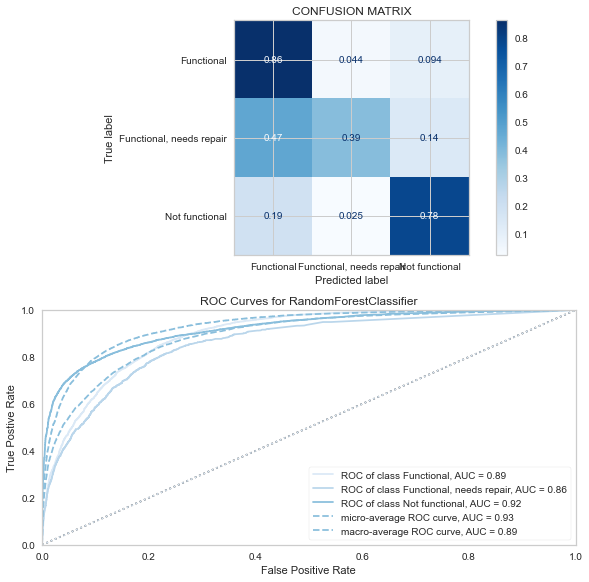

------------------------------------------------------------


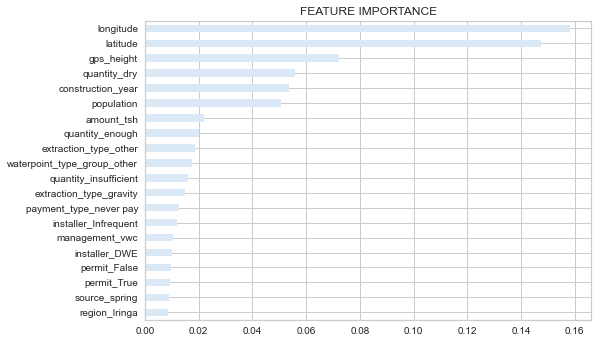

In [112]:
model_information(rf, X_test, y_test)

<div class="alert alert-block alert-info">

>Model is balanced.

---

**Precision**: How often is the prediction actually correct?
- 71%

---

**Recall**: How often does it predict correctly?
- 67%

---

**Accuracy**: Sum of true positives and true negatives divided by total number of samples.
- 80%

---

**Top Feature Importance**: Longitude, Latitude, gps_height, quantity_dry, construction year, and population are top factors that impact if the well is functional.

---

**Macro-Average ROC Curve, AUC**: Tells how much model is capable of distinguishing between classes. 
- 89%

---

### Adaboost

#### Adaboost Vanilla

In [113]:
adab = AdaBoostClassifier()

Testing Accuracy for Classifier: 71.95%
------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
                          precision    recall  f1-score   support

              Functional       0.70      0.89      0.79      8098
Functional, needs repair       0.36      0.05      0.08      1074
          Not functional       0.77      0.60      0.68      5678

                accuracy                           0.72     14850
               macro avg       0.61      0.51      0.51     14850
            weighted avg       0.70      0.72      0.69     14850

------------------------------------------------------------


/Users/laurenesser/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


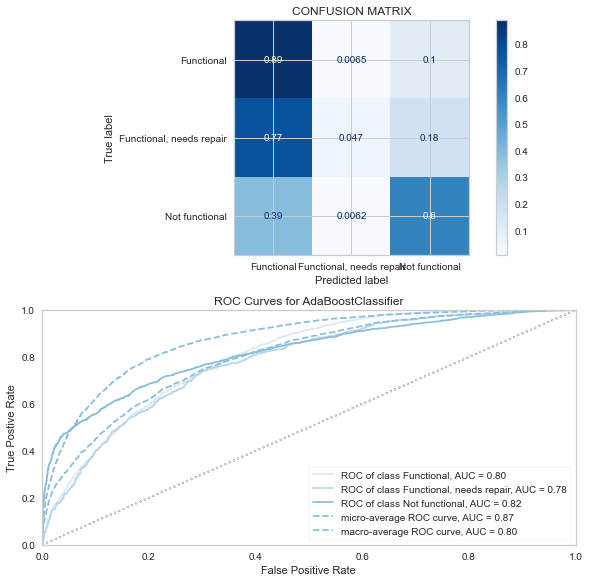

------------------------------------------------------------


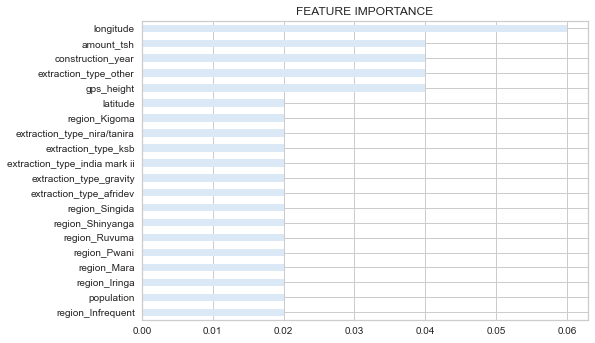

In [114]:
model_information(adab, X_test, y_test)

<div class="alert alert-block alert-info">

---

**Precision**: How often is the prediction actually correct?
- 61%

---

**Recall**: How often does it predict correctly?
- 51%

---

**Accuracy**: Sum of true positives and true negatives divided by total number of samples.
- 72%

---

**Top Feature Importance**: gps_height, longitude, extraction_type_other, amount_tsh, construction_year, region are top factors that impact if the well is functional.

---

**Macro-Average ROC Curve, AUC**: Tells how much model is capable of distinguishing between classes. 
- 80%

#### GridSearchCV Adaboost

In [115]:
#set params to search
param_grid = {
    'n_estimators': [50, 60, 70],
    'learning_rate': [.1, 1],
}

gs_adab = GridSearchCV(adab, param_grid, cv = 3)
gs_adab.fit(X_train, y_train)
print(f"Training Accuracy: {gs_adab.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {gs_adab.best_params_}")

Training Accuracy: 72.46%

Optimal Parameters: {'learning_rate': 1, 'n_estimators': 70}


In [116]:
#instantiate rf classifier
ada = AdaBoostClassifier(learning_rate =1, n_estimators = 70)

Testing Accuracy for Classifier: 72.49%
------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
                          precision    recall  f1-score   support

              Functional       0.71      0.89      0.79      8098
Functional, needs repair       0.39      0.05      0.09      1074
          Not functional       0.77      0.61      0.68      5678

                accuracy                           0.72     14850
               macro avg       0.62      0.52      0.52     14850
            weighted avg       0.71      0.72      0.70     14850

------------------------------------------------------------


/Users/laurenesser/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


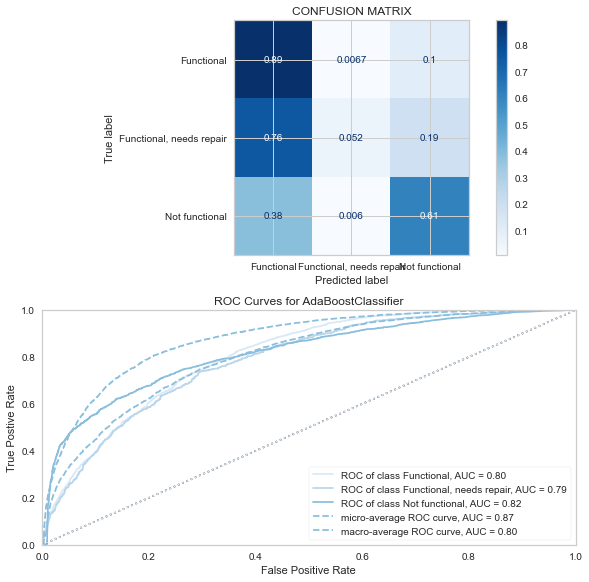

------------------------------------------------------------


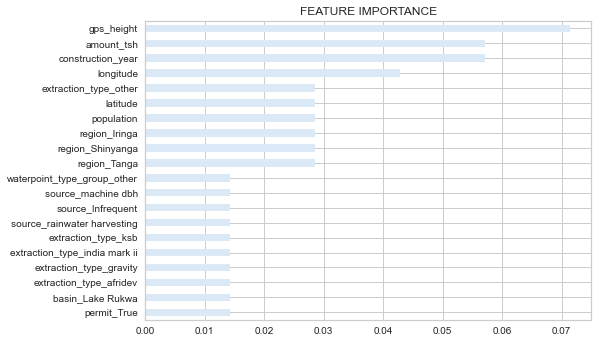

In [117]:
model_information(ada, X_test, y_test)

<div class="alert alert-block alert-info">

---

**Precision**: How often is the prediction actually correct?
- 60%

---

**Recall**: How often does it predict correctly?
- 52%

---

**Accuracy**: Sum of true positives and true negatives divided by total number of samples.
- 72%

---

**Top Feature Importance**: gps_height, longitude, extraction_type_other, amount_tsh, construction_year, region are top factors that impact if the well is functional.

---

**Macro-Average ROC Curve, AUC**: Tells how much model is capable of distinguishing between classes. 
- 80%

## Conclusion

For interpretation we will use the model found in Random Forest Grid Search. The reason we will use the Random Forest Model is because it had the highest accuracy.

### SHAP

In [118]:
import shap
shap.initjs()

In [119]:
#create smaller sample
X_shap = shap.sample(X_test, 120)

#instantiate explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_shap)

SHAP Summary Plot


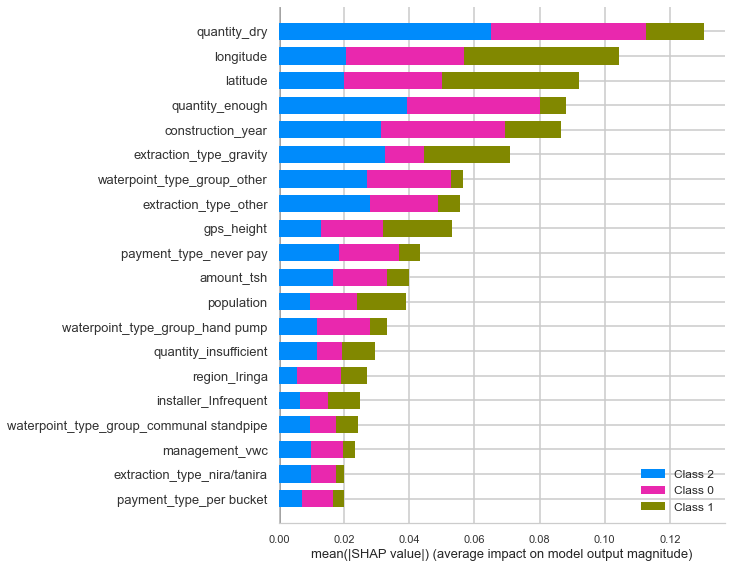

In [120]:
#plot summary
print("SHAP Summary Plot")
shap.summary_plot(shap_values, X_train, plot_type = 'bar')

<div class="alert alert-block alert-info"> 
The summary plot from shap really helps us to visualize steps the Tanzanian Ministry of Water can take in improving their wells. Focusing on Class 2 (Not Functional) We can look at specific items to focus on. Here we can see Quantity_dry, Quantity_enough, Extraction_type_gravity, Construction Year, Extraction_type_other, Waterpoint_type_group_other may be a great place to start. 

### Cross Model Validation

In [121]:
from sklearn.model_selection import cross_val_score

In [122]:
mean_rf_cv_score = np.mean(cross_val_score(rf, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

Mean Cross Validation Score for Random Forest Classifier: 79.25%


## Recommendations

In [123]:
#set_style
plt.style.use('seaborn-poster')

#set color palette for visualizations
sns.set_palette("Blues")

**1. Ensure the well has access to water**

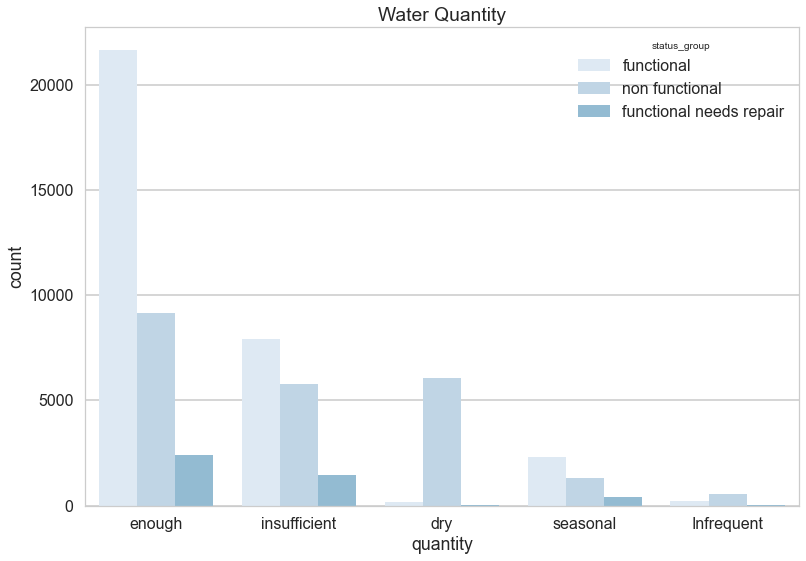

In [124]:
data_new = pd.concat([data_values, data_labels], axis =1)
data_new.head()
sns.countplot(data = data_new, x = "quantity", hue = "status_group").set_title("Water Quantity");

> Here we can see that if the water has dried up that the wells will not work. It is important to see that wells have an available water source. Based on the above image we can see that over 6000 wells have insufficient or dry quantity of water.

**2. Monitor wells that use extraction type of Gravity, Nira, or are labeled as "Other"**

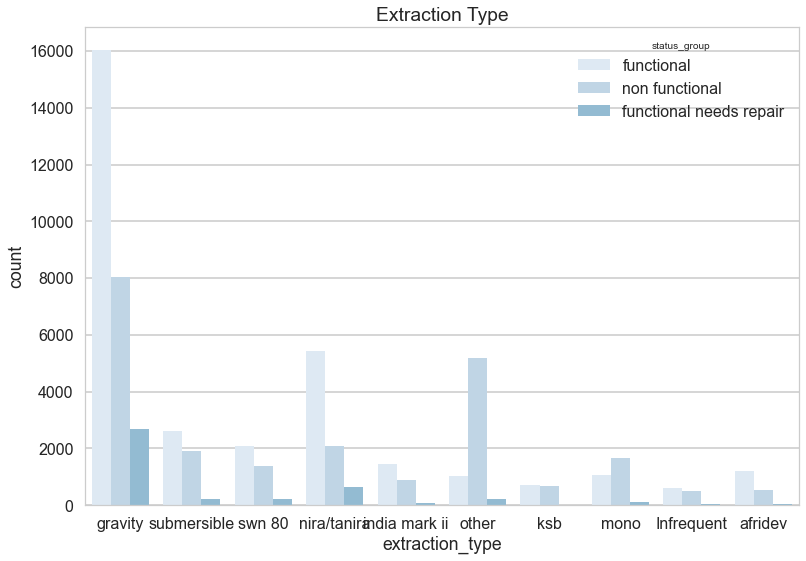

In [125]:
sns.countplot(data = data_new, x = "extraction_type", hue = "status_group").set_title("Extraction Type");

> In the above image we can see that gravity wells make up the majority of non-functional wells in Tanzania. By focusing on gravity type wells we would be able to identify wells that are not working quicker.

**3. Monitor wells that use waterpoint type of Handpump, Standpipe, or are labeled as "Other"**

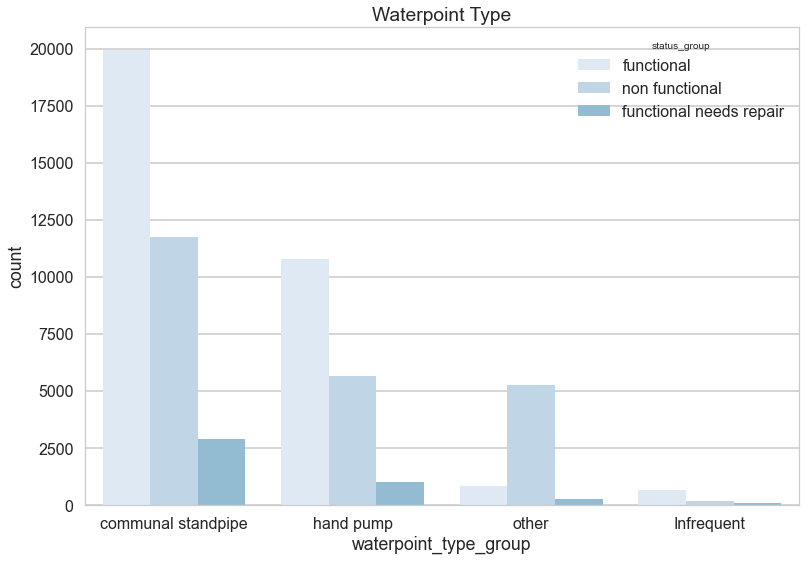

In [126]:
sns.countplot(data = data_new, x = "waterpoint_type_group", hue = "status_group").set_title("Waterpoint Type");

> Standpipe and hand pump make up the majority of non-functional wells. Communal standpipe alone has over 10,000 non-functional wells. 

**4. Inspect pumps that are built before 1965 or have no construction year listed**

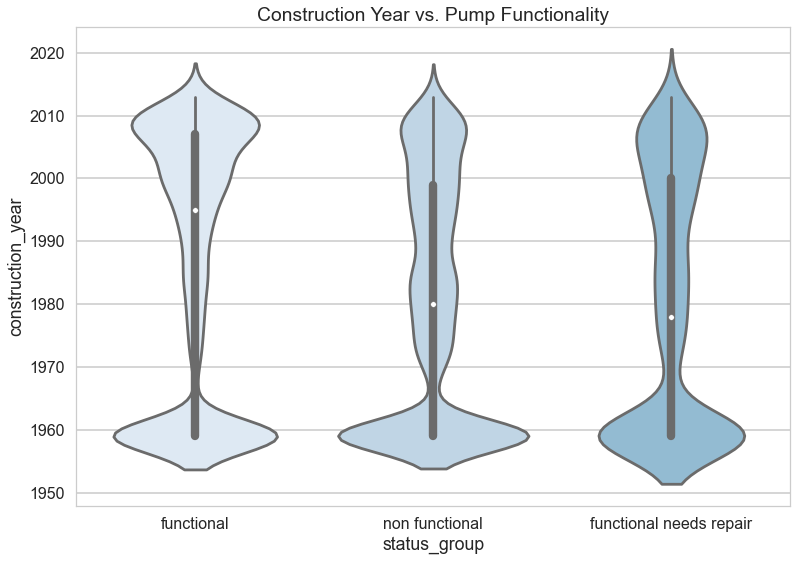

In [127]:
sns.violinplot(data = data_new, x = 'status_group', y= 'construction_year').set_title("Construction Year vs. Pump Functionality");

### Summary of Recommendations

<div class="alert-block alert-success">
    
1. Ensure water pumps have access to a water source.
    
2. Monitor wells that use extraction type of Gravity, Nira, or are labeled as “Other”.

3. Monitor wells that use waterpoint type of Handpump, Standpipe, or are labeled as “Other”. 

4. Inspect pumps that are built before 1965 or have no construction year listed.


### Next Steps

1. What are the "other" types of well extraction?
2. Does who manufactured the pump play a role in functionality?
3. Does number of dailty uses impact functionality?
4. Does distance from the ocean or a large body of water play a role?
5. Does the amount of pollution within the community play a role on functionality?

Thank you.